In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

In [1]:
# DATASET_PATH = 'train_sample'
DATASET_PATH = 'images'
MODEL_PATH = 'resnet18_letters.pth'

In [2]:
from model import SegmentCarNumber
import cv2

Вам предстоит создать алгоритм по деформации (выравниваню) автомобильных номеров и поместить его в функцию img_deformation.


! Вы не можете менять заданную OCR модель (дообучать тоже нельзя) и заданные шаблоны по разбиению изображения.

! Допустимы небольшие измениния трех основных .py файлов, если в этом есть необходимость для встраивания в ваши решения. Но их функционал должен быть сохранен.

# Файлы для работы с шаблонами

В разделе "Алогритм" показано что для чего нужно, так что имеет смысл сначала посетить его

## model.py

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18

label2letter = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "A", 11: "B", 12: "C", 13: "E", 14: "H", 15: "K", 16: "M", 17: "O", 18: "P", 19: "T", 20: "X", 21: "Y"
}

class LettersPrediction(object):
    def __init__(self):
        self.model = resnet18()
        self.model.fc = nn.Linear(self.model.fc.in_features, out_features=22)
        self.model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
        self.model.eval()

        self.imgsz = 64

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.imgsz, self.imgsz)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, img):
        input_tensor = self.transform(img)
        output_tensor = self.model(input_tensor.unsqueeze(0))
        predicted = torch.argmax(output_tensor)
        return label2letter[predicted.item()]

    def predict_series(self, imgs):
        s = ""
        for img in imgs:
            s += self.predict(img)
        return s

## template.py

Разбивает изображение на части по шаблонам

In [4]:
from pathlib import Path
import numpy as np

two_digit_region_template = [
    {'pos': 1, 'p1': (0.067, 0.250), 'p2': (0.177, 0.92)},
    {'pos': 2, 'p1': (0.19, 0.100), 'p2': (0.3, 0.92)},
    {'pos': 3, 'p1': (0.3, 0.100), 'p2': (0.41, 0.92)},
    {'pos': 4, 'p1': (0.41, 0.100), 'p2': (0.52, 0.92)},
    {'pos': 5, 'p1': (0.53, 0.250), 'p2': (0.64, 0.92)},
    {'pos': 6, 'p1': (0.64, 0.250), 'p2': (0.75, 0.92)},
    {'pos': 7, 'p1': (0.77, 0.05), 'p2': (0.86, 0.7)},
    {'pos': 8, 'p1': (0.86, 0.05), 'p2': (0.95, 0.7)}
]

three_digit_region_template = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

def apply_template(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
       raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    crops = []
    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = sx * W, sy * H, ex * W, ey * H
        sx, sy, ex, ey = map(int, [sx, sy, ex, ey])
        crops.append(img[sy : ey, sx : ex])

    return crops


## Функция для деформации

Пропишите логику алгоритма по деформации внутри фунции img_deformation

In [5]:
segm_num_net = SegmentCarNumber(encoder_path="encoder_weights.pth", unet_path="unet_model.pth")

In [6]:
def img_deformation(img):
    global segm_num_net
    """ БЛОК АЛГОРИТМА ПО ДЕФОРМАЦИИ ИЗОБРАЖЕНИЯ """



    """               КОНЕЦ БЛОКА                """
    img = segm_num_net.binary_model(
        segm_num_net.predict(img),
        cv2.imread(img)
    )[0]
    return img

In [7]:
def metric_similarity(y_true, y_pred):
    lst = []
    for i in range(len(y_true)):
        t = y_true[i]
        p = y_pred[i]
        c = 0
        for u in range(len(t)):
            try:
                if t[u] == p[u]:
                    c += 1
            except:
                pass
        lst.append(c / len(t))
    return sum(lst) / len(lst)

## predict.py

Выполняет предсказание для изображений разбитых по 2 и 3 шаблону

In [8]:
import argparse
from pathlib import Path
from tqdm import tqdm

import cv2
import pandas as pd

#from template import apply_template
#from model import LettersPrediction

data_path = Path(DATASET_PATH)


regions_type = [2, 3]
model = LettersPrediction()


result = []
for p in tqdm([i for i in data_path.iterdir()]):

    if not p.suffix in [".png", ".jpg", ".jpeg"]:
        continue
    result.append(
        {
            "image_name": p.stem,
            "prediction_region_length_2": "",
            "prediction_region_length_3": ""
        }
    )

    # img = cv2.imread(str(p))

    # #вызов фунции деформации
    # img = img_deformation(img)
    # ########################
    img = img_deformation(str(p))
    
    img = cv2.resize(img, (512, 112))

    for region_type in regions_type:

        crops = apply_template(img, region_type)

        lp_number = model.predict_series(crops)
        result[-1][f"prediction_region_length_{region_type}"] = lp_number

pd.DataFrame(result).to_csv('modelPredict.csv', index=False)


 12%|█▏        | 124/1029 [00:45<05:31,  2.73it/s]


ValueError: not enough values to unpack (expected 3, got 2)

# Алгоритм

![](https://sun9-2.userapi.com/impg/SfgCnkIYJeC_4clAh69dvC6ZwmBT9dLmMkh25A/DvScgey4ZCg.jpg?size=1916x1079&quality=96&sign=2ef5e9fadc1d8635c4963fb99affd07d&type=album)

In [ ]:
import matplotlib.pyplot as plt
import os

#Рисует на изображение template
def draw_regions(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
        raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = int(sx * W), int(sy * H), int(ex * W), int(ey * H)
        cv2.rectangle(img, (sx, sy), (ex, ey), (0, 255, 0), 2)

    return img

#Визуализирует изображения из датасета
def draw(folder_path, show_template=False, template=2, count_image=None):

    file_list = os.listdir(folder_path)[:count_image] if count_image else os.listdir(folder_path)
    image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Устанавливаем количество изображений на строку
    images_per_row = 5

    num_rows = len(image_files) // images_per_row + int(len(image_files) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(image_files):
            ax = axes.flat[i]
            img_path = os.path.join(folder_path, image_files[i])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if show_template:
              img = img_deformation(img_path)
              img = cv2.resize(img, (512,112))
              img_with_rectangles = draw_regions(img, template)

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(img_path))
        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()


Визуализируем изображения из датасета

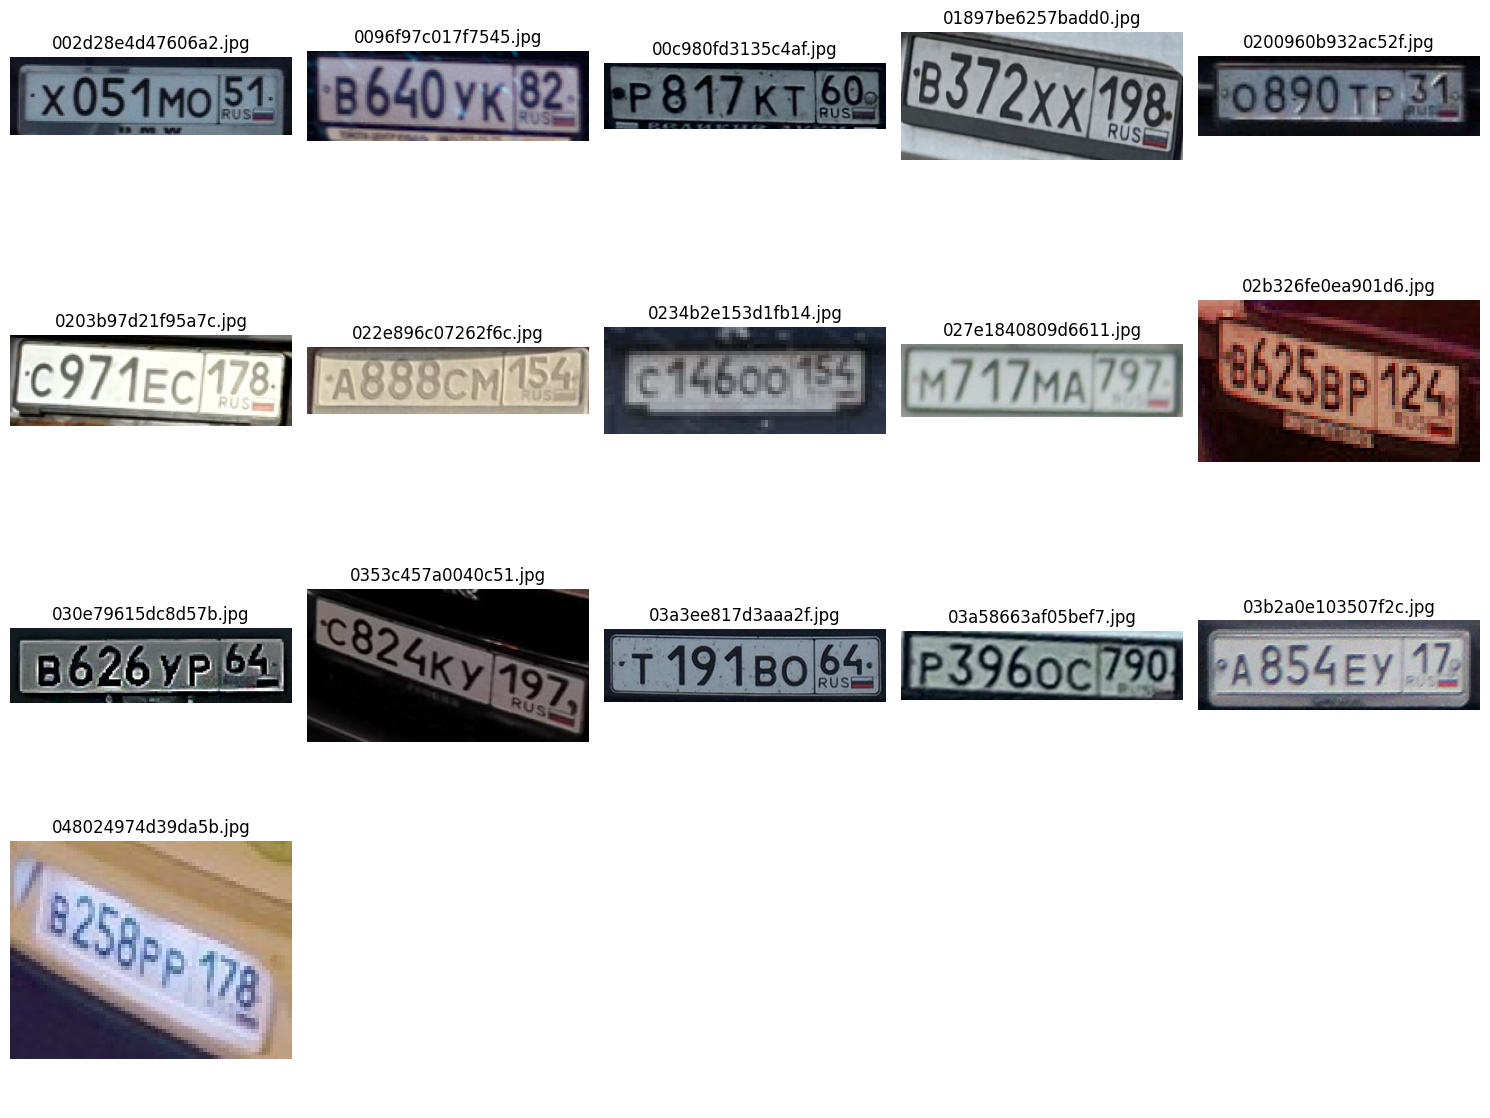

In [ ]:
draw(DATASET_PATH, show_template=False, count_image=16)

Теперь визуализируем шаблон 2 для каждого изображения

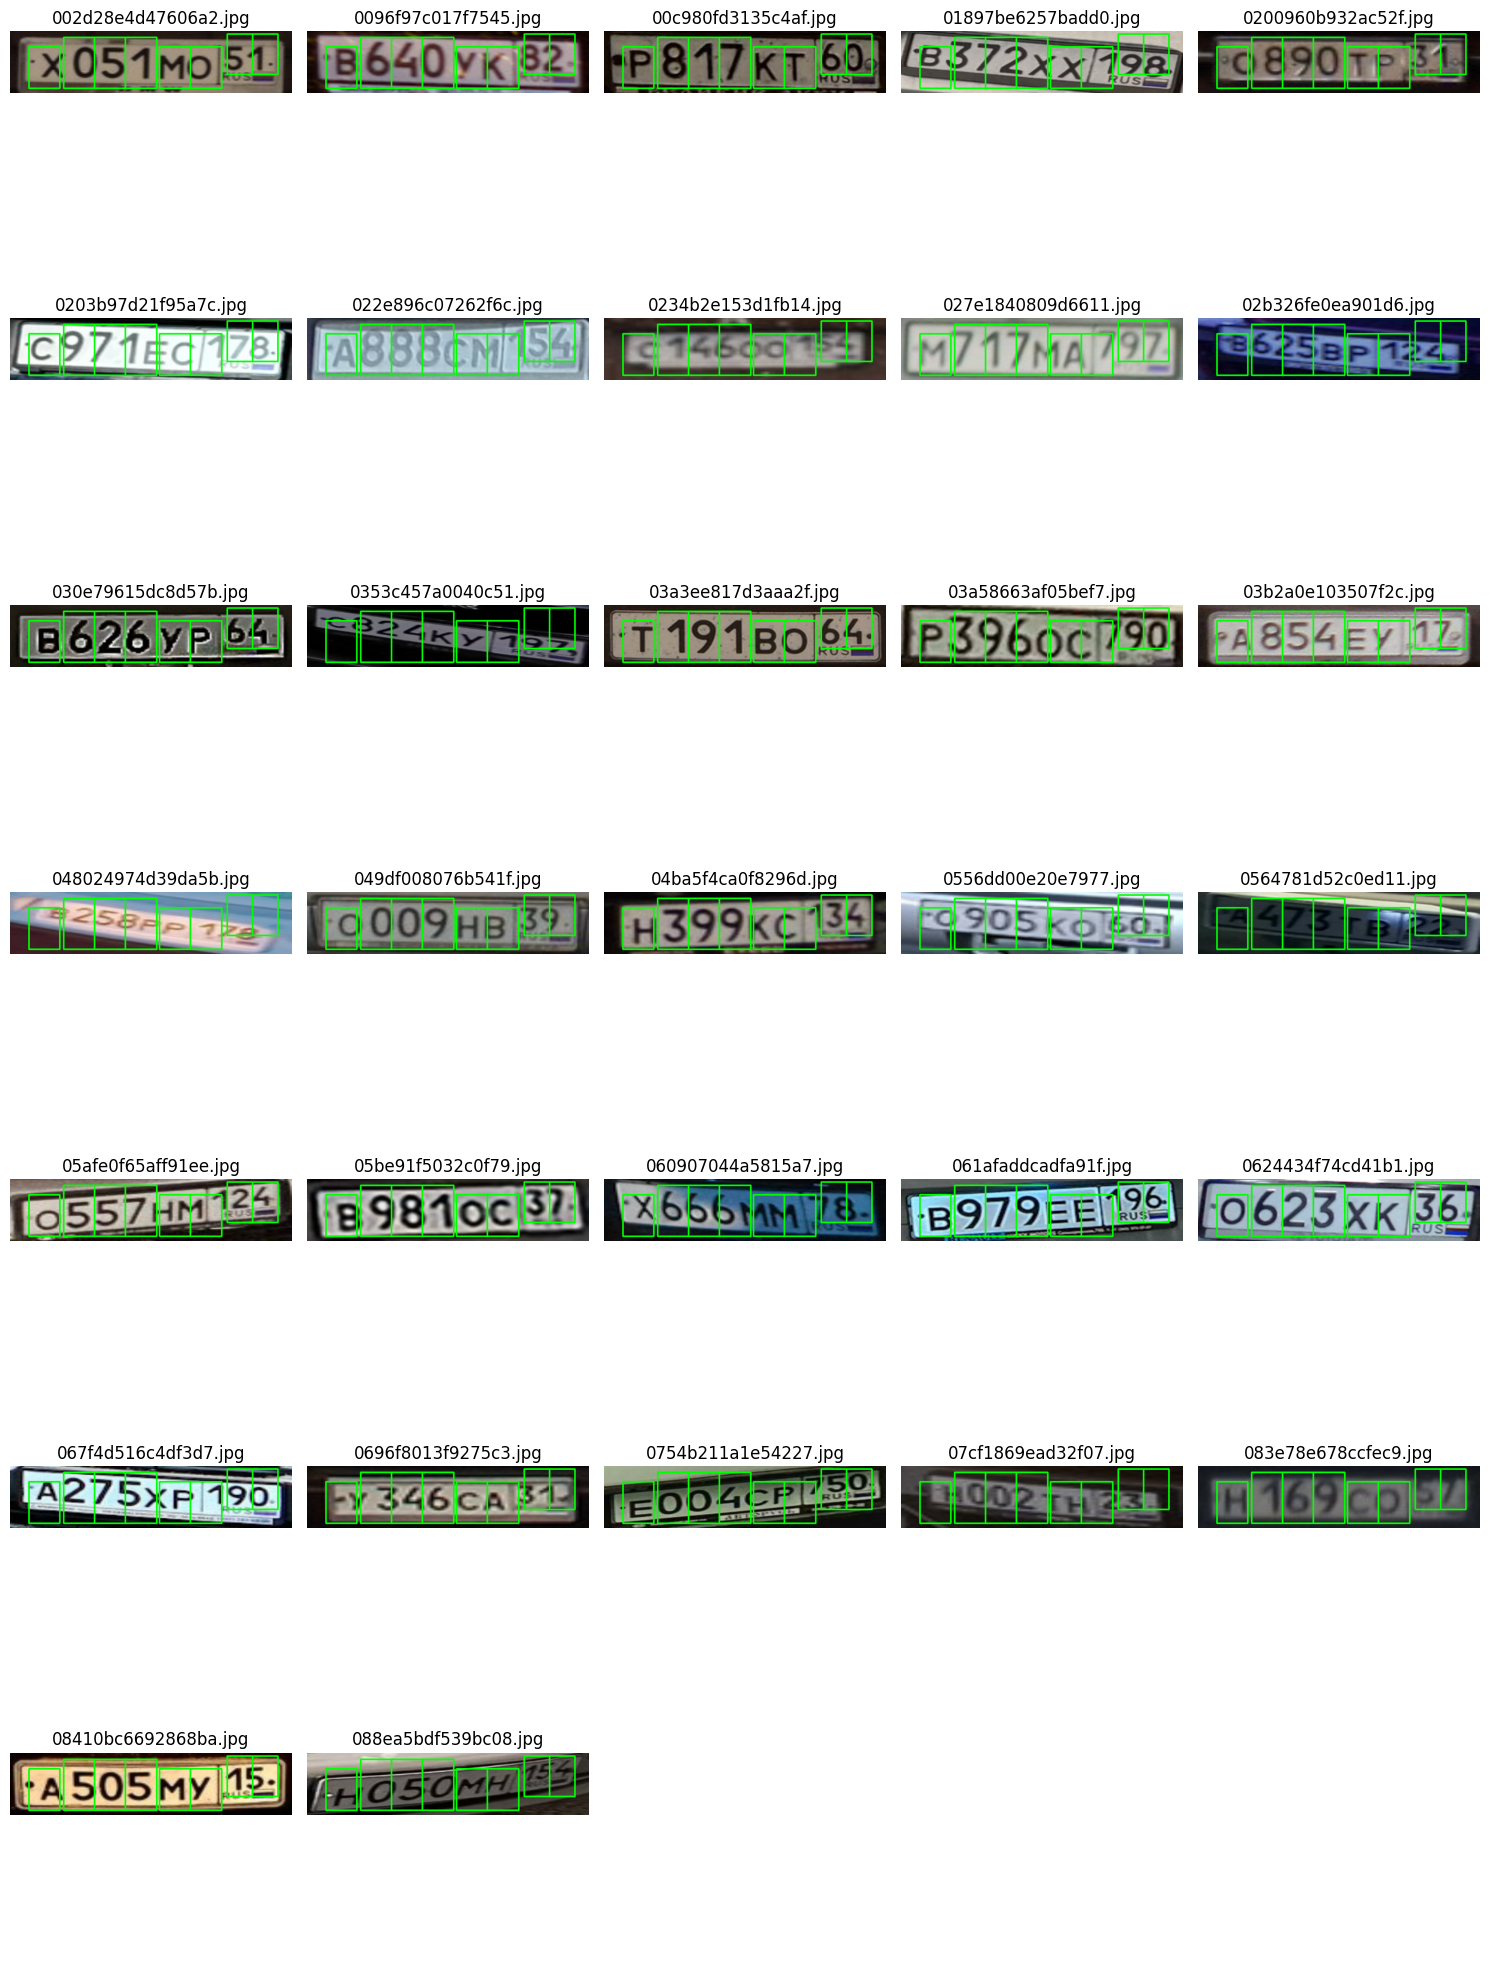

In [ ]:
draw(DATASET_PATH, show_template=True, count_image=32)

Теперь визуализируем шаблон 3 для каждого изображения

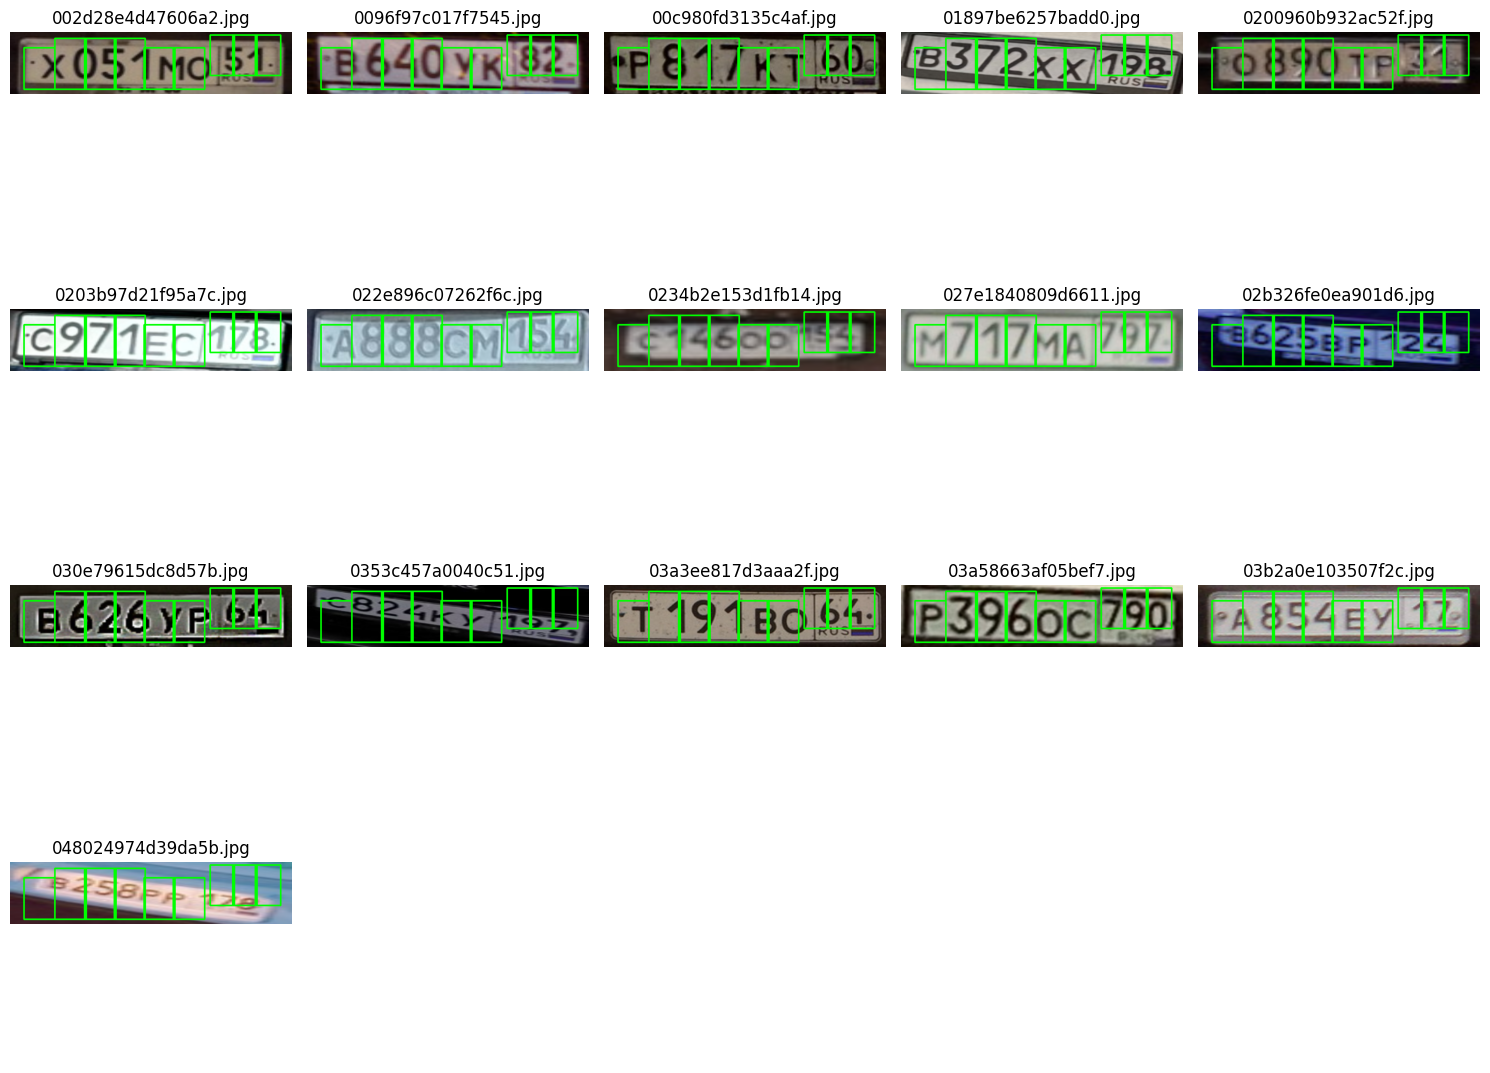

In [ ]:
draw(DATASET_PATH, show_template=True, template=3, count_image=16)

# Вывод модели

In [ ]:
df = pd.read_csv('modelPredict.csv')

Модель делает предсказание разбивая изображение и по шаблону 2 и по шаблону 3.

In [ ]:
df

,image_name,prediction_region_length_2,prediction_region_length_3
0,002d28e4d47606a2,4O51MO5E,2O54HOT4H
1,0096f97c017f7545,E64OYC62,E648YAT22
2,00c980fd3135c4af,E817CT5O,E8MHM4T3C
3,01897be6257badd0,44224266,8422CO456
4,0200960b932ac52f,589OT4C0,545OME311
...,...,...,...
1024,fe8f3cff0cf76166,Y929EE64,4529THT44
1025,fed01b5793ae24dc,462EOM75,4515HOT73
1026,ff670e356ab0fee5,4944115C,4965O415C
1027,ff84142ca87fed63,0P116197,0012HO777


In [ ]:
Y = pd.read_csv('correspondance.csv')

In [ ]:
Y

,image_name,number
0,37483d050adca57c,M592OK198
1,c350610c6c56aec1,B011EK37
2,e8ff37a2fd046525,C337AY774
3,6be42e5f4705e24b,Y243KH790
4,4520ec3542ae89f7,T405CK150
...,...,...
1024,1193e820021376fd,H787MM30
1025,de86687b51b964e6,Y019HO30
1026,2596303dfed6beee,E110ME178
1027,678766229b7e4996,A851KA37


In [ ]:
metric_similarity(y_true=Y['number'], y_pred=df['prediction_region_length_2'])

0.06077907353417581

In [ ]:
metric_similarity(y_true=Y['number'], y_pred=df['prediction_region_length_3'])

0.07130709426627832